# **Detecting `Pausing`, `Playing` and `Buffering` States**



### History of Improvements
- Initially experimented with packet length, packet size change, time interval features
    - Extremely High Accuracy -> Overfitting
    - Basically randomly guessing on test dataset
- Experimenting with protocols, maybe they could give some important information, eventually added time_since_last_protocol
    - After much testing found a promising feature in time_since_last_DNS, gave me around 56% accuracy by itself and in combination with other protocol features
    - Thought adding rolling_median_time_since_last_protocol, rolling_avg_time_since_last_protocol would make sense intuitively but saw almost  nno improvement
        - Important: Implemented with a rolling value of 20
- Constantly tested against a testing dataset, so I could detect and prevent any overfitting with features
- Further experimenting with features involving DNS
    - Became aware of how insignificant the rolling value for median calculation was, accuracy increased to 70%
    - further tuned the parameters to n_estimators = 20 and max_depth=5 to increase accuracy to 75%
- Recall, Precision and f1 scores indicate how my model is proficient in differentiationg between buffering and non buffering state, and has more difficulty differentiatiing between playing and paused 

In [ ]:

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from trustee import ClassificationTrustee

from sklearn import metrics
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
scaler = StandardScaler()

dataset_path = '../datasets/combined_batches.csv'
test_dataset_path = '../datasets/test_batches.csv'
features_to_drop = ['rolling_std_time_since_last_DNS', 'rolling_var_time_since_last_DNS', 'ratio_time_since_last_DNS_avg', 'rolling_avg_time_since_last_DNS', 'time_since_last_DNS', 'curr_state']

In [8]:
df = pd.read_csv(dataset_path)
targets = df['curr_state']
features = df


median_dns = features['time_since_last_DNS'].median()
features['ratio_time_since_last_DNS'] = features['time_since_last_DNS'] / median_dns

avg_dns = features['rolling_avg_time_since_last_DNS'].median()
features['ratio_time_since_last_DNS_avg'] = features['time_since_last_DNS'] / avg_dns

features['time_since_last_DNS' ] = scaler.fit_transform(features['time_since_last_DNS'].values.reshape(-1, 1))
features['ratio_time_since_last_DNS' ] = scaler.fit_transform(features['ratio_time_since_last_DNS'].values.reshape(-1, 1))
features['ratio_time_since_last_DNS_avg' ] = scaler.fit_transform(features['ratio_time_since_last_DNS_avg'].values.reshape(-1, 1))

features = features.drop(features_to_drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, random_state=42)

clf = RandomForestClassifier(
    n_estimators=20,
    max_depth=5,  
    min_samples_split=6, 
    min_samples_leaf=8,  
    max_features='sqrt', 
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Playing', 'Paused', 'Buffering']))

importances = clf.feature_importances_
feature_names = features.columns
feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

for feature, importance in feature_importances:
    print(f"{feature}: {importance}")
    

Accuracy: 0.7524381376391683

Classification Report:
               precision    recall  f1-score   support

     Playing       0.73      0.69      0.71    417259
      Paused       0.70      0.72      0.71    417924
   Buffering       0.83      0.85      0.84    419053

    accuracy                           0.75   1254236
   macro avg       0.75      0.75      0.75   1254236
weighted avg       0.75      0.75      0.75   1254236

ratio_time_since_last_DNS: 0.5209691063435197
rolling_median_time_since_last_DNS: 0.4790308936564804


In [5]:

test_df = pd.read_csv('../datasets/test_batches.csv')

y_test = test_df['curr_state']
X_test = test_df
median_dns = X_test['time_since_last_DNS'].median()
X_test['ratio_time_since_last_DNS'] = X_test['time_since_last_DNS'] / median_dns

avg_dns = X_test['rolling_avg_time_since_last_DNS'].median()
X_test['ratio_time_since_last_DNS_avg'] = X_test['time_since_last_DNS'] / avg_dns


X_test['time_since_last_DNS' ] = scaler.fit_transform(X_test['time_since_last_DNS'].values.reshape(-1, 1))
X_test['ratio_time_since_last_DNS' ] = scaler.fit_transform(X_test['ratio_time_since_last_DNS'].values.reshape(-1, 1))
X_test['ratio_time_since_last_DNS_avg' ] = scaler.fit_transform(X_test['ratio_time_since_last_DNS_avg'].values.reshape(-1, 1))
X_test = X_test.drop(features_to_drop, axis=1)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=['Playing', 'Paused', 'Buffering'])

print("Test Dataset Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)

Test Dataset Accuracy: 0.7541075761564899

Classification Report:
               precision    recall  f1-score   support

     Playing       0.70      0.71      0.71    421599
      Paused       0.72      0.69      0.70    421599
   Buffering       0.83      0.86      0.85    421599

    accuracy                           0.75   1264797
   macro avg       0.75      0.75      0.75   1264797
weighted avg       0.75      0.75      0.75   1264797



Training score of pruned DT: 0.9999862011954191
Model explanation global fidelity report:


/Users/luisbravo/Projects/detecting_pauses/venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           1       0.99      0.91      0.95    917407
           2       0.93      0.98      0.95   1008140
           3       0.97      0.99      0.98   1001002

    accuracy                           0.96   2926549
   macro avg       0.97      0.96      0.96   2926549
weighted avg       0.96      0.96      0.96   2926549

Model explanation score report:
              precision    recall  f1-score   support

           1       0.75      0.65      0.70    976336
           2       0.68      0.74      0.71    975671
           3       0.81      0.85      0.83    974542

    accuracy                           0.75   2926549
   macro avg       0.75      0.75      0.74   2926549
weighted avg       0.75      0.75      0.74   2926549



[Text(0.5138888888888888, 0.9375, 'ratio_time_since_last_DNS <= 0.052\ngini = 0.666\nsamples = 1024291\nvalue = [320783, 353655, 349853]\nclass = Paused'),
 Text(0.25, 0.8125, 'rolling_median_time_since_last_DNS <= 1.585\ngini = 0.577\nsamples = 649874\nvalue = [250727, 334271, 64876]\nclass = Paused'),
 Text(0.19444444444444445, 0.6875, 'rolling_median_time_since_last_DNS <= 1.037\ngini = 0.558\nsamples = 580011\nvalue = [181507, 334271, 64233]\nclass = Paused'),
 Text(0.1388888888888889, 0.5625, 'gini = 0.005\nsamples = 41714\nvalue = [41607, 107, 0]\nclass = Buffering'),
 Text(0.25, 0.5625, 'rolling_median_time_since_last_DNS <= 1.2\ngini = 0.533\nsamples = 538297\nvalue = [139900, 334164, 64233]\nclass = Paused'),
 Text(0.1111111111111111, 0.4375, 'ratio_time_since_last_DNS <= -0.204\ngini = 0.236\nsamples = 228909\nvalue = [1374, 197798, 29737]\nclass = Paused'),
 Text(0.05555555555555555, 0.3125, 'gini = 0.019\nsamples = 199350\nvalue = [1145, 197478, 727]\nclass = Paused'),
 Tex

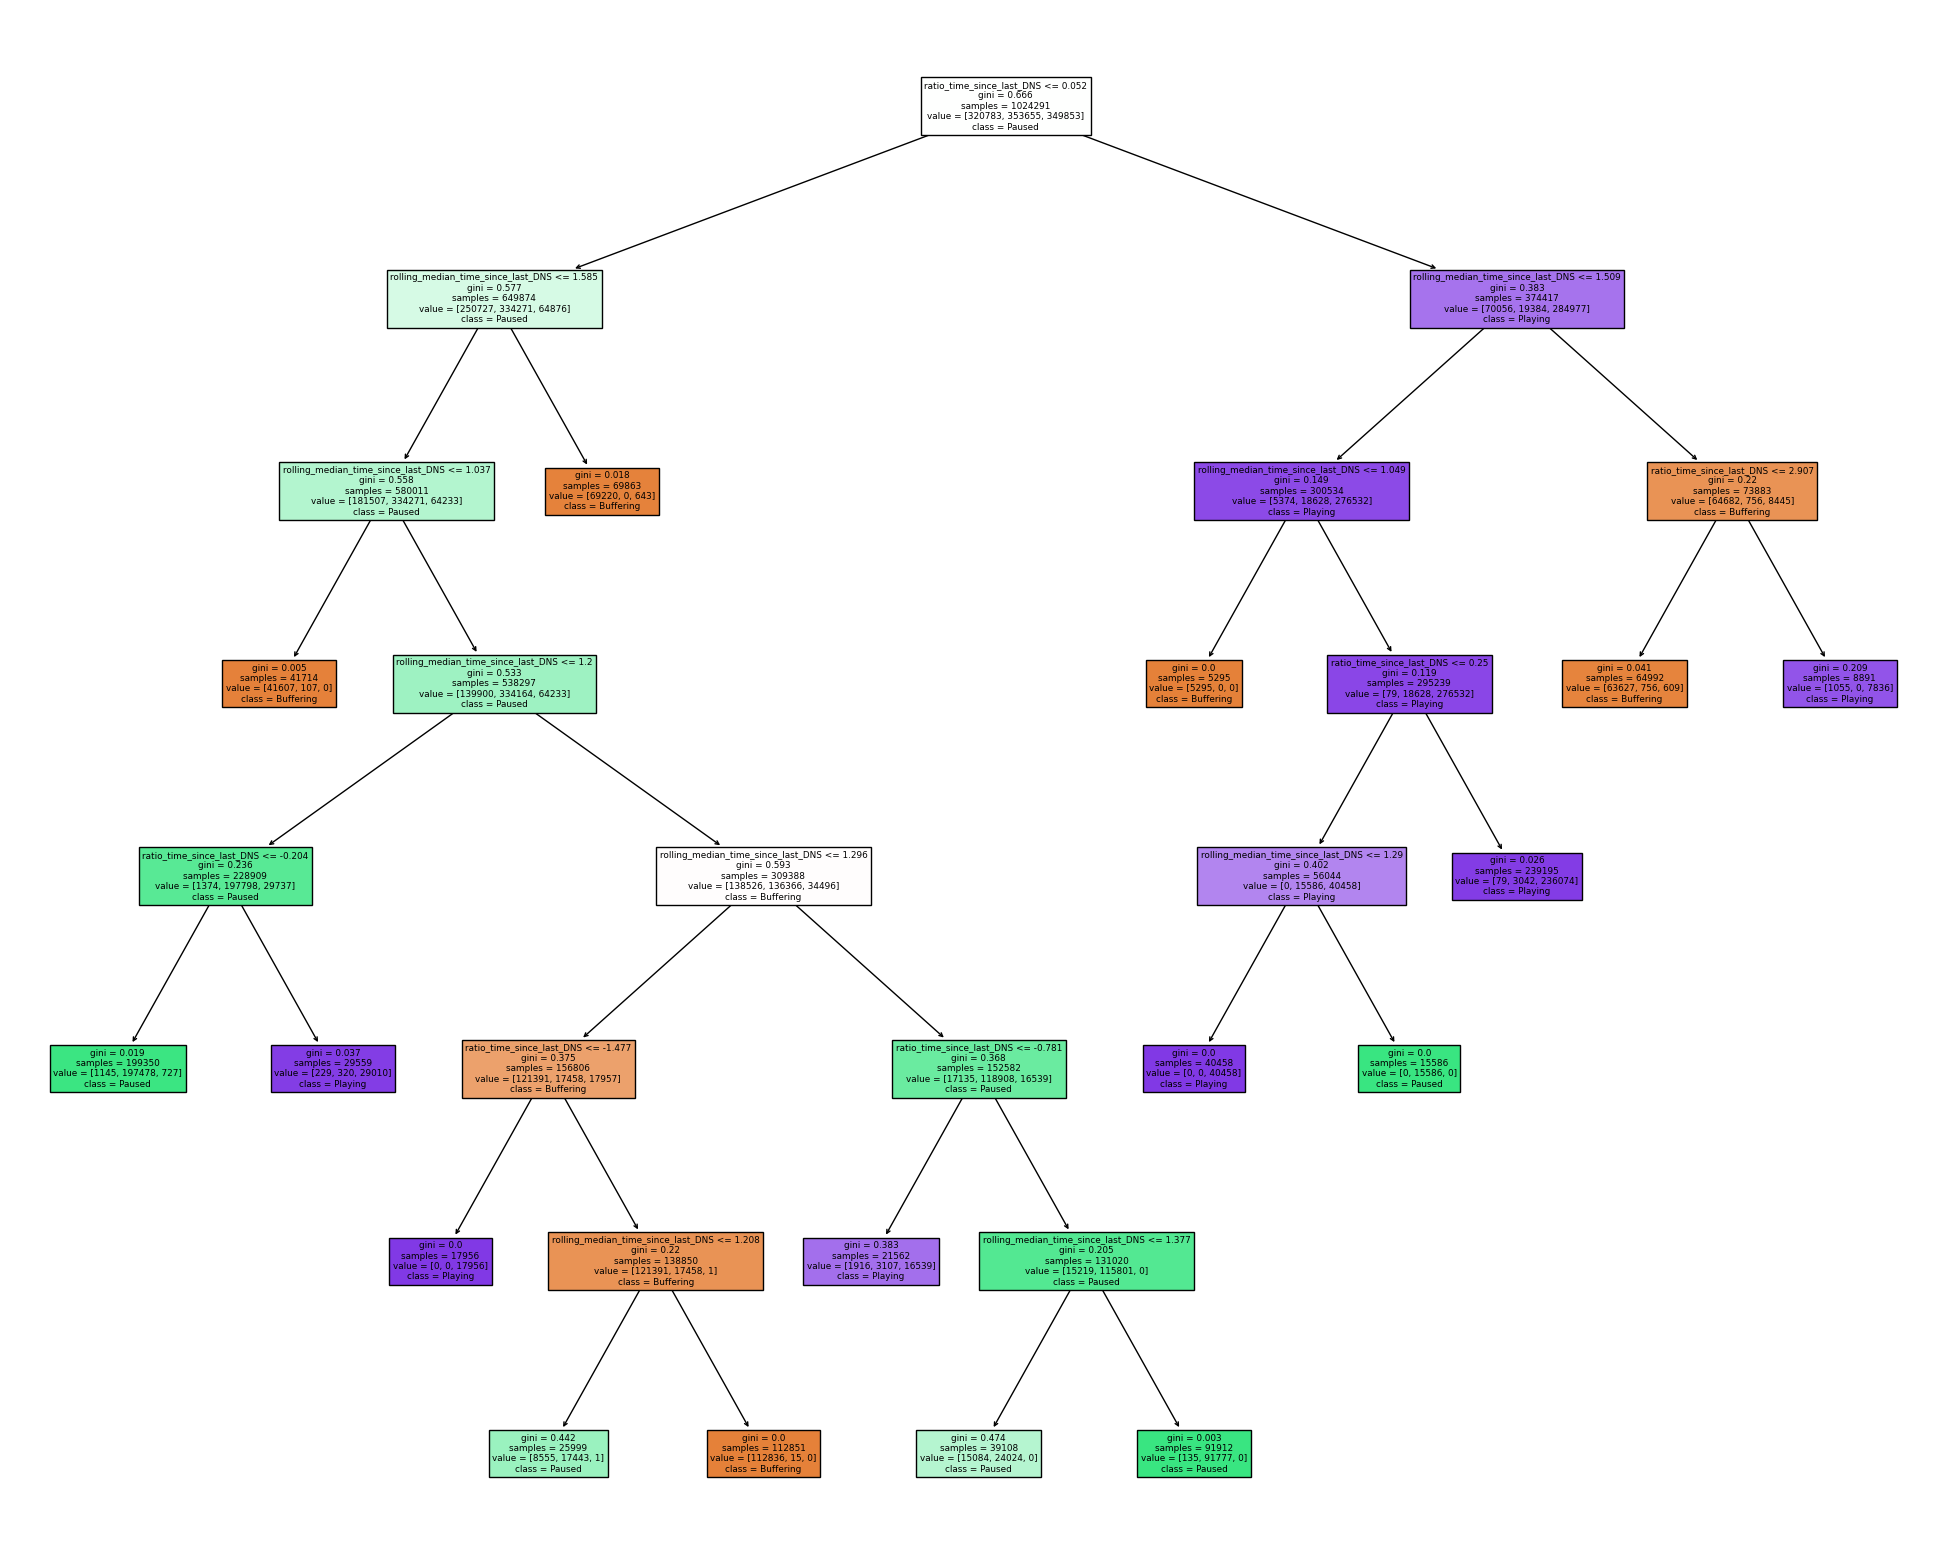

In [6]:

trustee = ClassificationTrustee(expert=clf)
trustee.fit(X_train, y_train, num_samples=len(X_train) // 2, num_iter=10,train_size=0.70)

_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")
dt_y_pred = dt.predict(X_train)
print("Model explanation global fidelity report:")
print(metrics.classification_report(clf.predict(X_train), dt_y_pred))
print("Model explanation score report:")
print(metrics.classification_report(y_train, dt_y_pred))

fig = plt.figure(figsize=(25,20))
plot_tree(dt, feature_names=X_train.columns, class_names=sorted(["Playing", "Paused", "Buffering"]), filled=True, max_depth=7)